Possible Visualizations:
1. World Map color coded by cluster
2. Plot to visualize the shifts

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math
%matplotlib inline
plt.style.use('seaborn')
import os
import seaborn as sns

In [4]:
BASE_DIR = '/content/drive/My Drive/4th Year/CS 197 (Thesis)/FINAL - COVID Modeling/notebooks/data/'
df_kmeans = pd.read_csv(os.path.join(BASE_DIR, 'new_clustered_countries.csv'), index_col=0)
df_kshape = pd.read_csv(os.path.join(BASE_DIR, 'new_clustered_countries_kshape.csv'), index_col=0)
df_outliers = pd.read_csv(os.path.join(BASE_DIR, 'outlier_countries.csv'), index_col=0)

In [5]:
df_kmeans['labels'] = df_kmeans['labels'] + 1
df_kmeans.head()

Province/State Country/Region       Lat  ...  shift 75  shift 76 labels
0    no province    Afghanistan  33.93911  ...      -1.0        -1      3
1    no province        Albania  41.15330  ...      -1.0        -1      1
2    no province        Algeria  28.03390  ...      -1.0        -1      3
3    no province        Andorra  42.50630  ...      -1.0        -1      4
4    no province         Angola -11.20270  ...      -1.0        -1      1

[5 rows x 987 columns]

In [6]:
df_kshape['labels'] = df_kshape['labels'] + 1
df_kshape.head()

Province/State Country/Region       Lat  ...  shift 33  shift 34 labels
0    no province    Afghanistan  33.93911  ...        -1        -1      5
1    no province        Albania  41.15330  ...        -1        -1      6
2    no province        Algeria  28.03390  ...        -1        -1      5
3    no province        Andorra  42.50630  ...        -1        -1      4
4    no province         Angola -11.20270  ...        -1        -1      2

[5 rows x 824 columns]

In [7]:
df_outliers.head()

Province/State       Country/Region  ...  11/16/20  11/17/20
3                   no province              Andorra  ...        42        37
4                   no province               Angola  ...       164       203
5                   no province  Antigua and Barbuda  ...         0         0
8  Australian Capital Territory            Australia  ...         0         1
9               New South Wales            Australia  ...         4         7

[5 rows x 310 columns]

# Removing Outlier Countries
Commenting out this section because this was _before_ we removed the outliers at the start of the pipeline already.

In [ ]:
# df_kshape_no_outliers = df_kshape[~df_kshape['area'].isin(df_outliers['area'])]
# df_kshape_no_outliers.head()

Province/State Country/Region       Lat  ...  shift 34  shift 35 labels
0    no province    Afghanistan  33.93911  ...        -1        -1      3
1    no province        Albania  41.15330  ...        -1        -1      3
2    no province        Algeria  28.03390  ...        -1        -1      3
6    no province      Argentina -38.41610  ...        -1        -1      3
7    no province        Armenia  40.06910  ...        -1        -1      3

[5 rows x 1216 columns]

In [ ]:
# df_kmeans_no_outliers = df_kmeans[~df_kmeans.index.isin(df_outliers.index)]
# df_kmeans_no_outliers.head()

Province/State Country/Region       Lat  ...  shift 75  shift 76 labels
0    no province    Afghanistan  33.93911  ...      -1.0        -1      3
1    no province        Albania  41.15330  ...      -1.0        -1      1
2    no province        Algeria  28.03390  ...      -1.0        -1      3
6    no province      Argentina -38.41610  ...      -1.0        -1      1
7    no province        Armenia  40.06910  ...      -1.0        -1      1

[5 rows x 987 columns]

# Visualizing the Clusters

In [7]:
def get_random_color():
  import random
  r = lambda: random.randint(0,255)
  return ('#%02X%02X%02X' % (r(),r(),r()))
  # return list(np.random.choice(range(0, 1), size=3))

In [8]:
# All countries
def get_single_graph(df, area):
  last_columns = 37

  fig, ax = plt.subplots(3, 1, figsize=(30,15))
  titles = ["Confirmed", "Fatality Rate", "Recovery Rate"]

  columns = df.columns[6:-last_columns]
  num_columns = len(columns) // 3
  df_cluster = df[df['area'] == area]

  for i in range(3):
    ax[i].set_title(titles[i])
    ax[i].set_xlabel("Dates")
    ax[i].set_ylabel("Normalized Cases")
    ax[i].get_xaxis().set_ticks([])

    x = columns[i*num_columns:i*num_columns + num_columns]

    for idx, curr_area in df_cluster.iterrows():
      y = curr_area[x]
      
      ax[i].plot(x,y,label=curr_area['area'])

  fig.suptitle('{} Normalized Cases'.format(area), fontsize=18)

In [9]:
# Consensus - mean of each date
def get_consensus(df, cluster_num=0):
  last_columns = 37

  columns = df.columns[6:-last_columns]
  num_columns = len(columns) // 3
  df_cluster = df[df['labels'] == cluster_num]
  new_row = {
    'area': 'Consensus #%d' % cluster_num, 
    'label': cluster_num,
  }

  for col in columns:
    df_curr_date = df_cluster[col]
    stat = df_curr_date.mean()
    # stat = df_curr_date.median()
    new_row[col] = stat

  fig, ax = plt.subplots(3, 1, figsize=(18,10))
  titles = ["Confirmed", "Fatality Rate", "Recovery Rate"]

  for i in range(3):
    ax[i].set_title(titles[i])
    ax[i].set_xlabel("Dates")
    ax[i].set_ylabel("Normalized Cases")
    ax[i].get_xaxis().set_ticks([])

    x = columns[i*num_columns:i*num_columns + num_columns]
    y = [value for key, value in new_row.items() if key in x]
      
    ax[i].plot(x,y)

  fig.suptitle('Cluster #{} Consensus Graphs'.format(cluster_num), fontsize=18)

  return new_row

In [45]:
# Shift the columns of each row so that it starts with one zero and then the
# rest are the nonzero values
def shift_df_cols(df, num_divs):
  labels = ['confirmed', 'deaths']
  # labels = ['confirmed', 'deaths', 'recoveries']
  columns = df.columns
  num_columns = len(columns) // num_divs

  shifted_df = pd.DataFrame()
  for idx, row in df.iterrows():
    combined_series = []
    for i in range(num_divs):
      curr_cols = columns[i*num_columns:i*num_columns + num_columns]
      temp = row[curr_cols] != 0
      # Get the first nonzero column in each country onwards
      curr_cols = curr_cols[curr_cols.get_loc(temp.idxmax()):]
      shifted_row = row[curr_cols]
      shifted_row.index = [labels[i] + '_' + f'{col_idx+1:03d}' for col_idx in range(len(shifted_row.index))]
      combined_series.append(shifted_row)
    combined_series = pd.concat(combined_series, axis=0)

    shifted_df = shifted_df.append(combined_series)
  
  shifted_df['confirmed_000'] = 0
  shifted_df['deaths_000'] = 0
  # shifted_df['recoveries_000'] = 0

  shifted_df = shifted_df.reindex(sorted(shifted_df.columns), axis=1)
  
  return shifted_df

# Consensus - mean of each change in cases
def get_consensus_2(df, cluster_num=0, num_divs=2):
  last_columns = 36

  columns = df.columns[6:-last_columns]
  df_cluster = df[df['labels'] == cluster_num][columns]

  shifted_df = shift_df_cols(df_cluster, num_divs)

  shifted_cols = shifted_df.columns
  num_columns = len(shifted_cols) // num_divs
  added_columns = []
  for idx, col in enumerate(shifted_cols):
    if num_columns % (idx + num_columns) == 0:
      added_columns.append(0)
    else:
      mean_of_difference = (shifted_df[col] - shifted_df[shifted_cols[idx-1]]).mean()
      # mean_of_difference = (shifted_df[col] - shifted_df[shifted_cols[idx-1]]).median()
      new_column = added_columns[-1] + mean_of_difference
      added_columns.append(new_column)

  new_row = {col: row for col, row in zip(shifted_cols, added_columns)}
  new_row['area'] = 'Consensus #%d' % cluster_num
  new_row['label'] = cluster_num

  fig, ax = plt.subplots(num_divs, 1, figsize=(18,10))
  titles = ["Confirmed", "Fatality Rate", "Recovery Rate"]

  for i in range(num_divs):
    ax[i].set_title(titles[i])
    ax[i].set_xlabel("Dates")
    ax[i].set_ylabel("Normalized Cases")
    ax[i].get_xaxis().set_ticks([])

    x = shifted_cols[i*num_columns:i*num_columns + num_columns]
    y = added_columns[i*num_columns:i*num_columns + num_columns]
      
    ax[i].plot(x,y)

  fig.suptitle('Cluster #{} Consensus Graphs'.format(cluster_num), fontsize=18)

  return new_row

# get_consensus_2(df_kshape, cluster_num=1)

In [19]:
# All countries
def get_graphs(df, cluster_num=0, num_divs=2):
  last_columns = 36

  fig, ax = plt.subplots(num_divs, 1, figsize=(30,15))
  titles = ["Confirmed", "Fatality Rate", "Recovery Rate"]

  columns = df.columns[6:-last_columns]
  num_columns = len(columns) // num_divs
  df_cluster = df[df['labels'] == cluster_num]

  n_colors = df_cluster.shape[0]

  for i in range(num_divs):
    ax[i].set_title(titles[i])
    ax[i].set_xlabel("Dates")
    ax[i].set_ylabel("Normalized Cases")
    ax[i].get_xaxis().set_ticks([])

    x = columns[i*num_columns:i*num_columns + num_columns]

    for idx, area in df_cluster.iterrows():
      y = area[x]
      
      # ax[i].plot(x,y,label=area['area'], color=get_random_color())
      ax[i].plot(x,y,label=area['area'])

  fig.suptitle('Cluster #{} Normalized Cases'.format(cluster_num), fontsize=18)
  #comment out the line below to remove the labels of the area names.
  fig.legend(df_cluster['area'])

  fig.savefig(f'cluster_{cluster_num}.png')

## K-shape

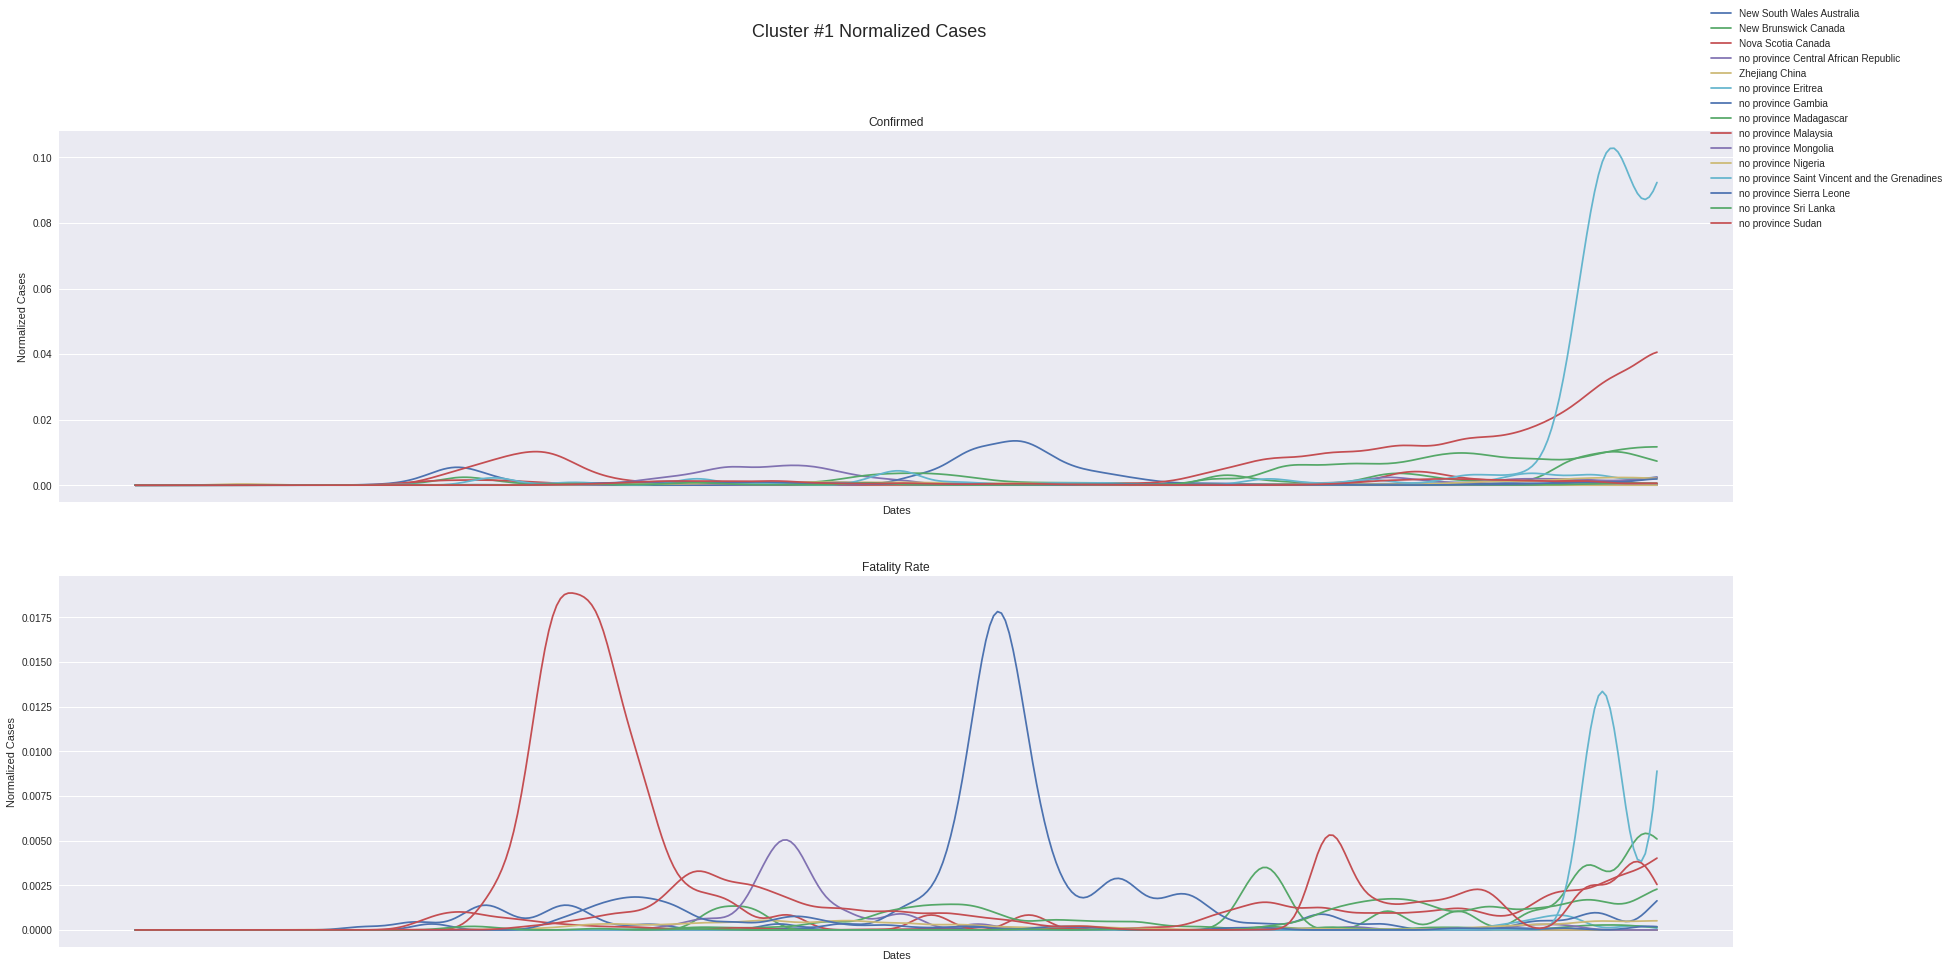

In [20]:
get_graphs(df_kshape, cluster_num=1)

In [21]:
# get_single_graph(df_kshape, 'no province Nepal')
# df_kshape[df_kshape['Country/Region'] == 'Serbia']['11/15/20_confirmed']

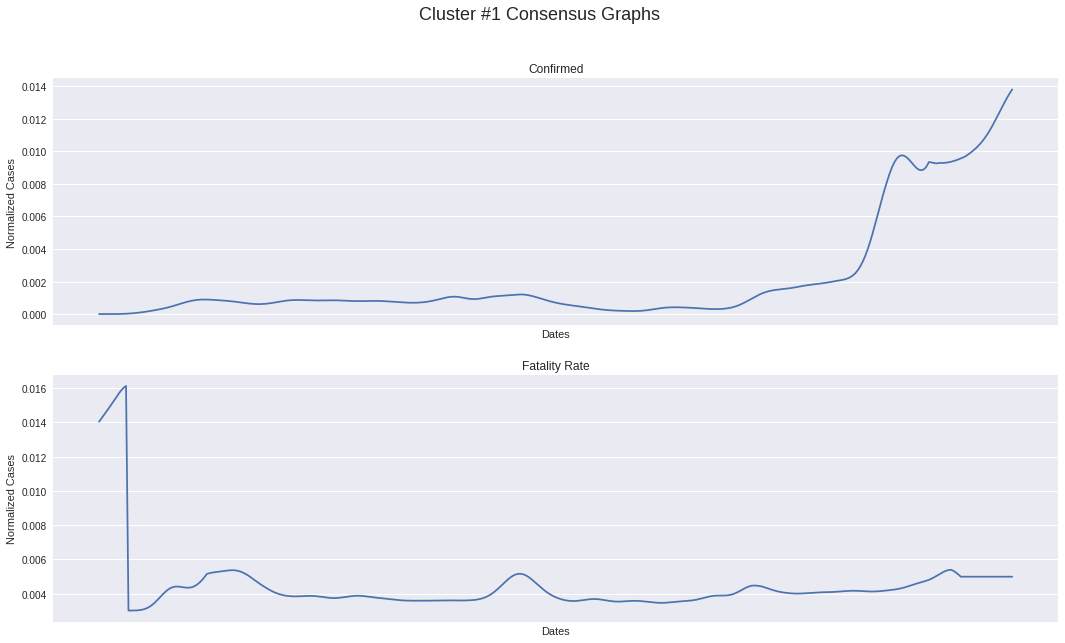

In [22]:
cluster0_kshape = get_consensus_2(df_kshape, cluster_num=1)

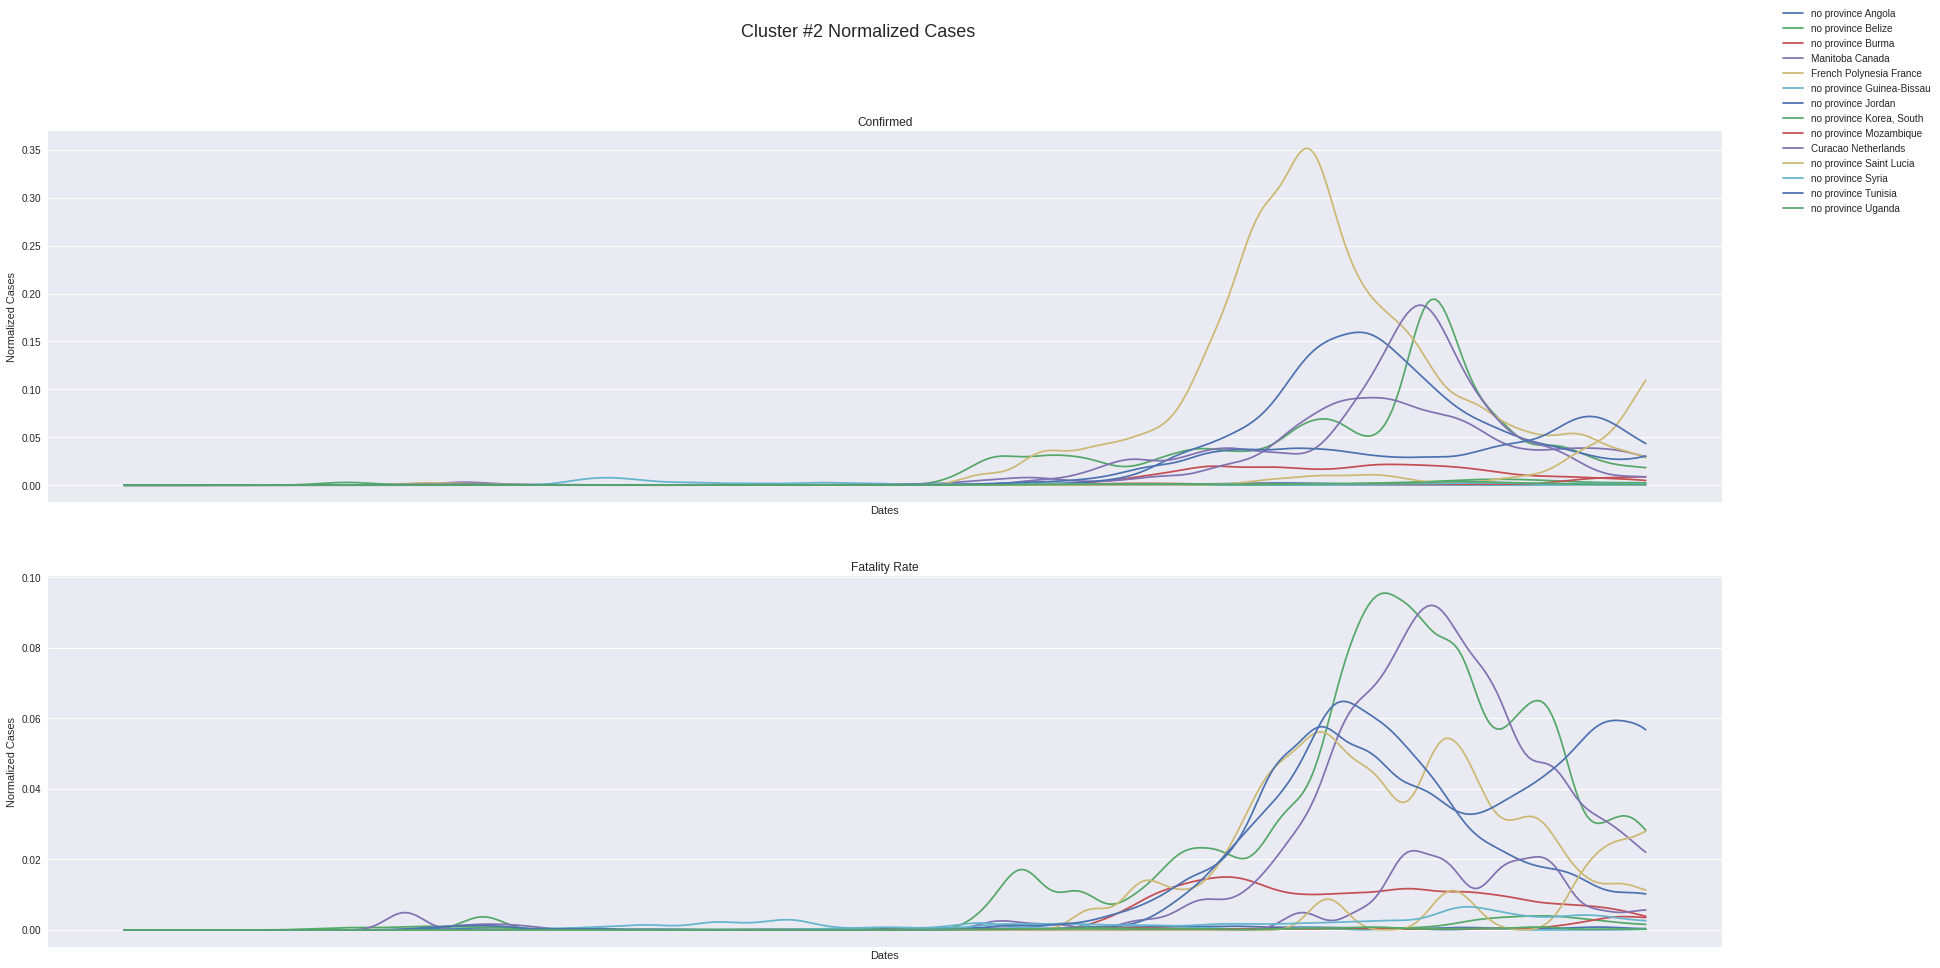

In [23]:
get_graphs(df_kshape, cluster_num=2)

In [24]:
# NUM_COLUMNS = len(df_kshape.columns[6:-78]) // 3
# df_kshape[df_kshape['labels'] == 0][(df_kshape[df_kshape.columns[6:NUM_COLUMNS+6]] > 0.2).any(axis=1)]

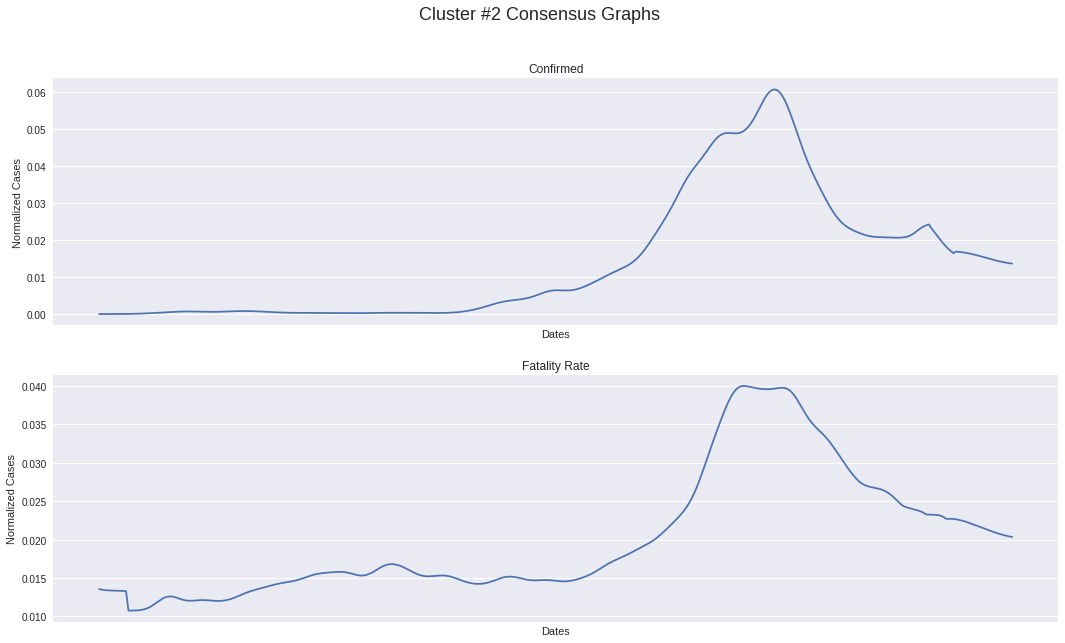

In [25]:
cluster1_kshape = get_consensus_2(df_kshape, cluster_num=2)

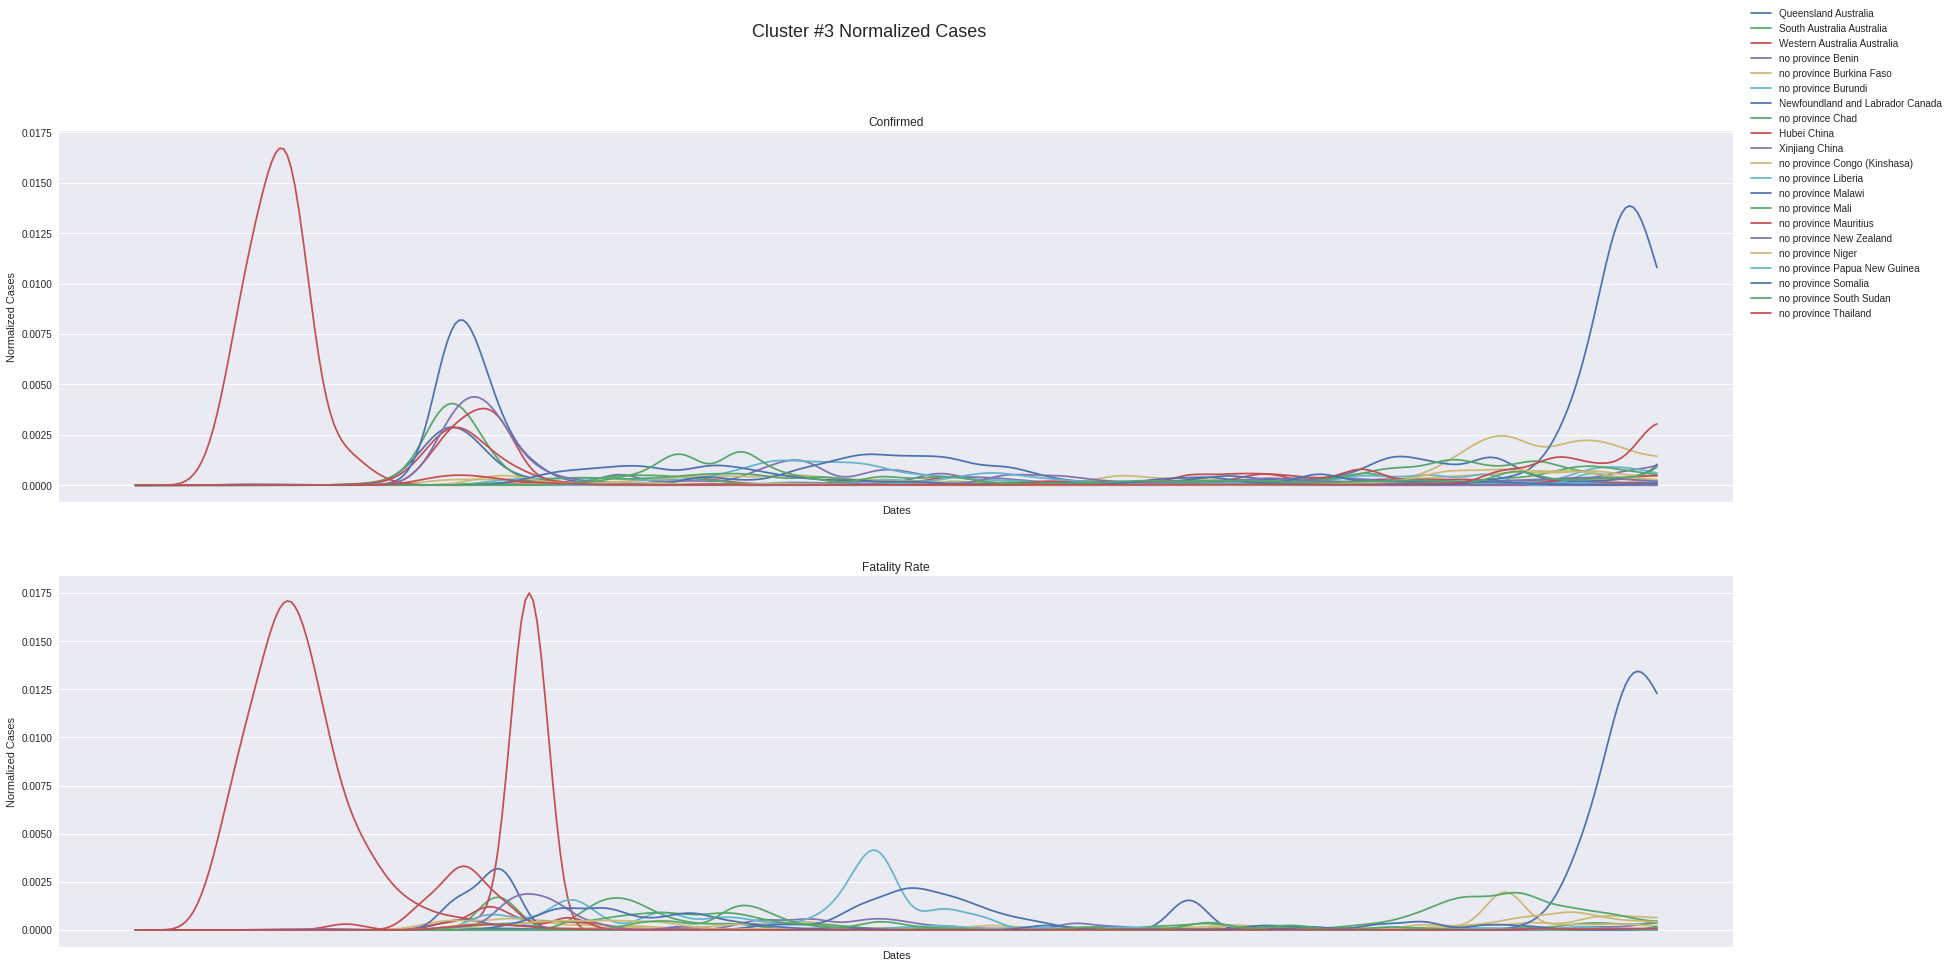

In [26]:
get_graphs(df_kshape, cluster_num=3)

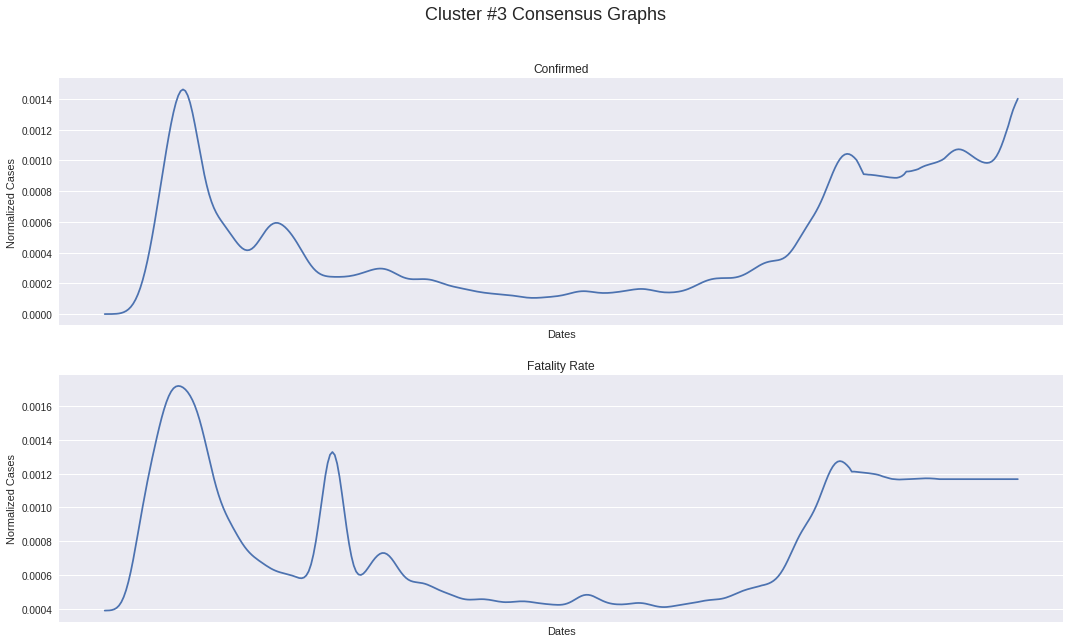

In [27]:
cluster2_kshape = get_consensus_2(df_kshape, cluster_num=3)

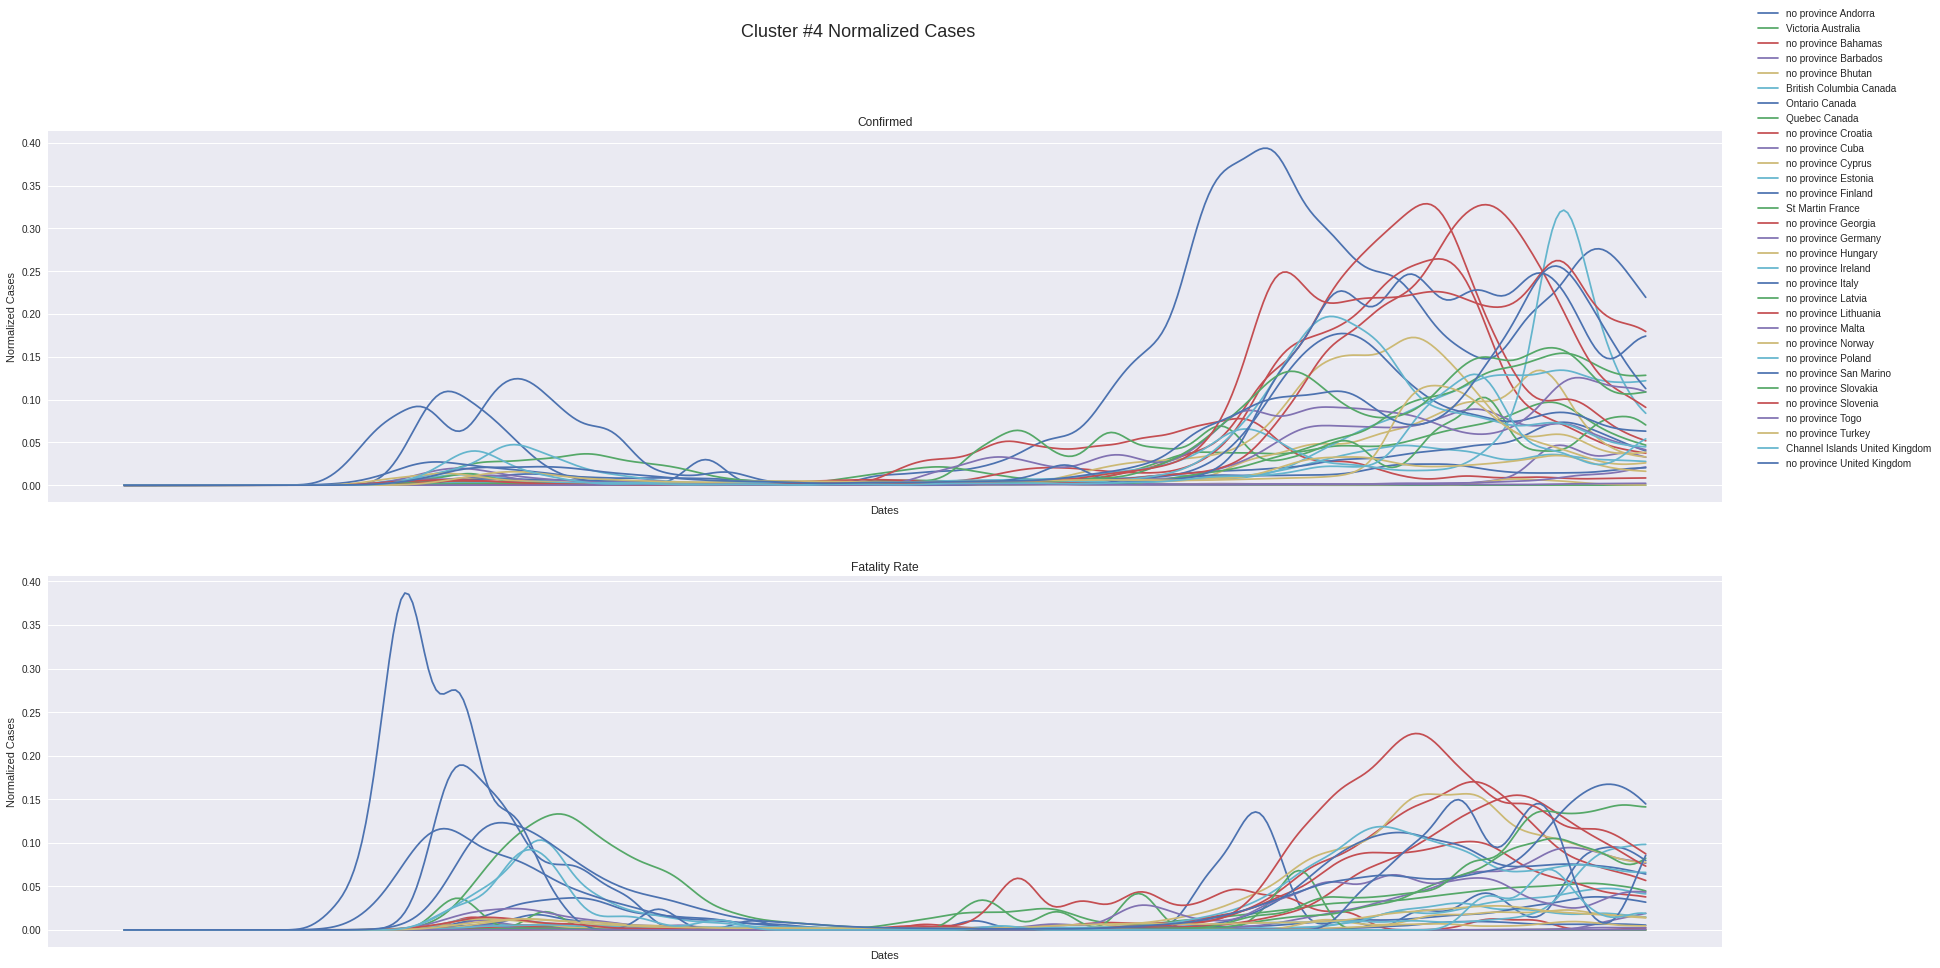

In [28]:
get_graphs(df_kshape, cluster_num=4)

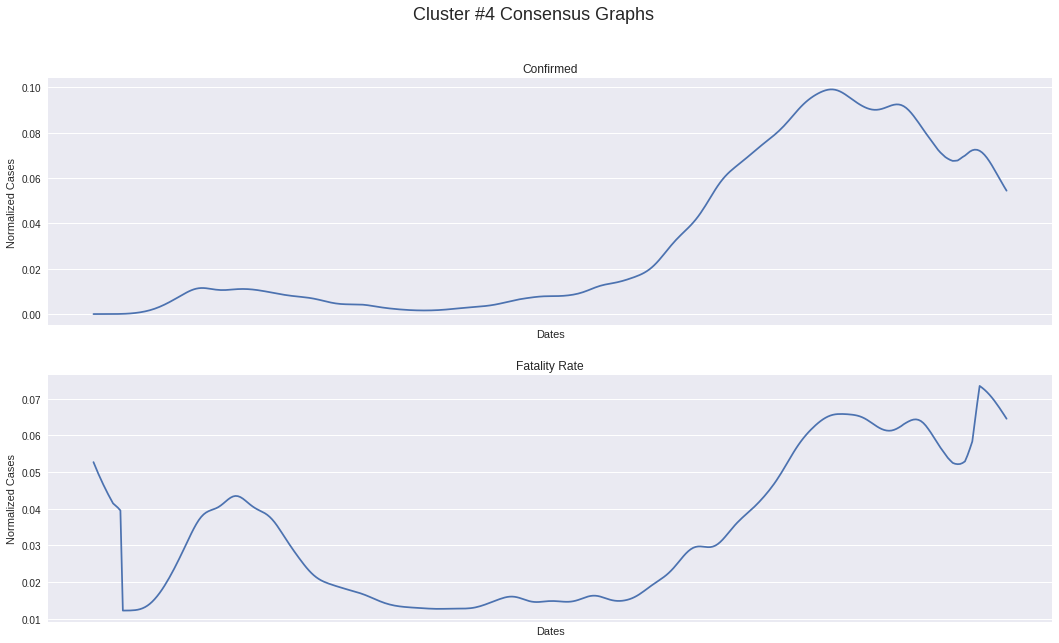

In [29]:
cluster3_kshape = get_consensus_2(df_kshape, cluster_num=4)

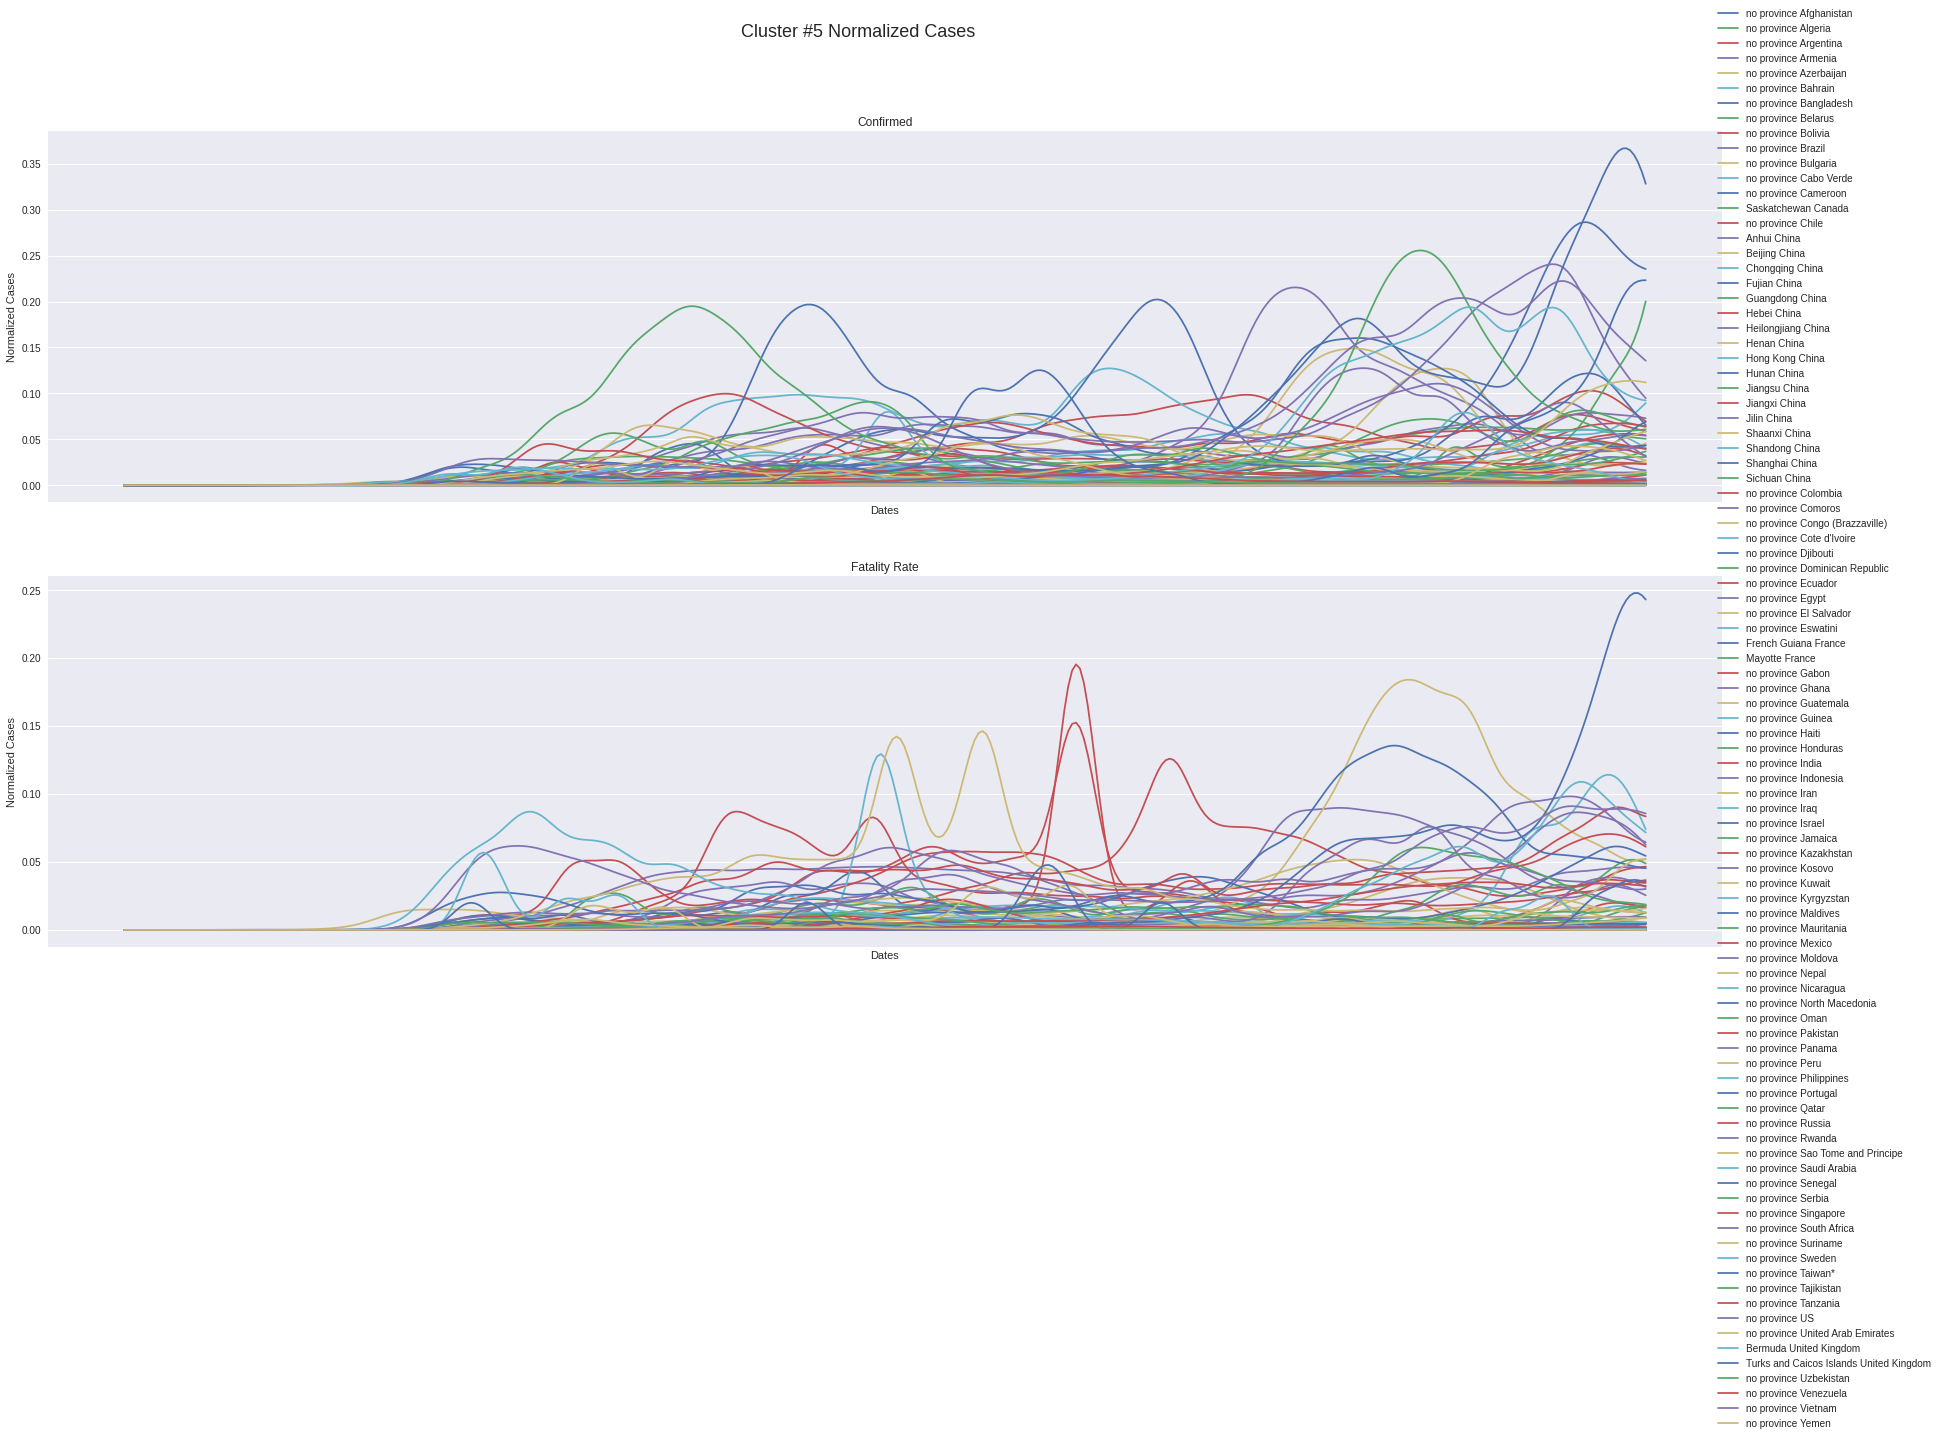

In [30]:
get_graphs(df_kshape, cluster_num=5)

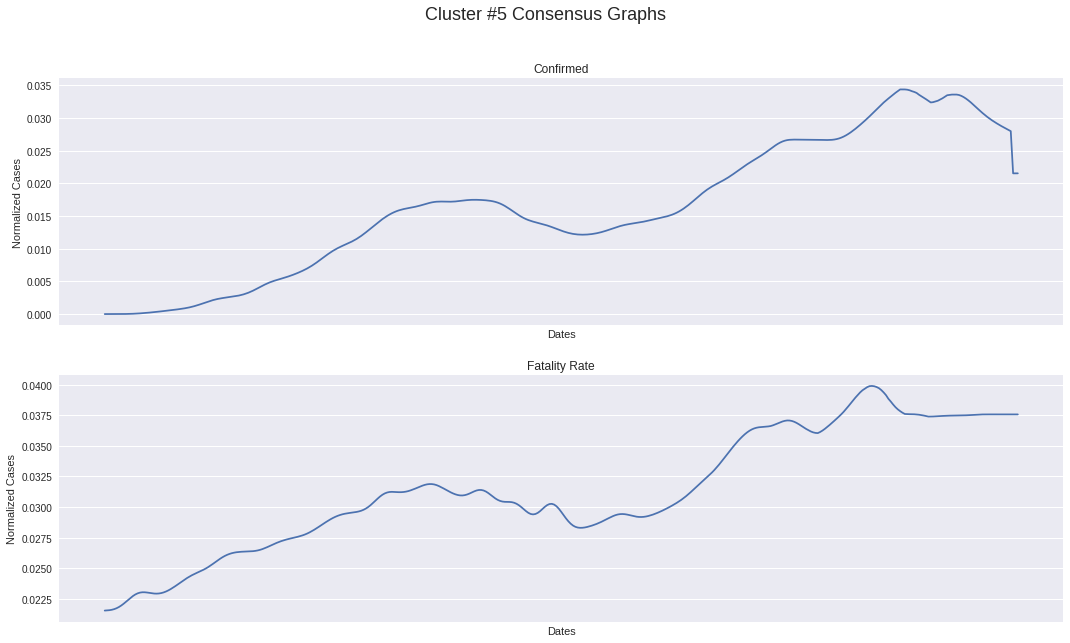

In [31]:
cluster4_kshape = get_consensus_2(df_kshape, cluster_num=5)

## K-means

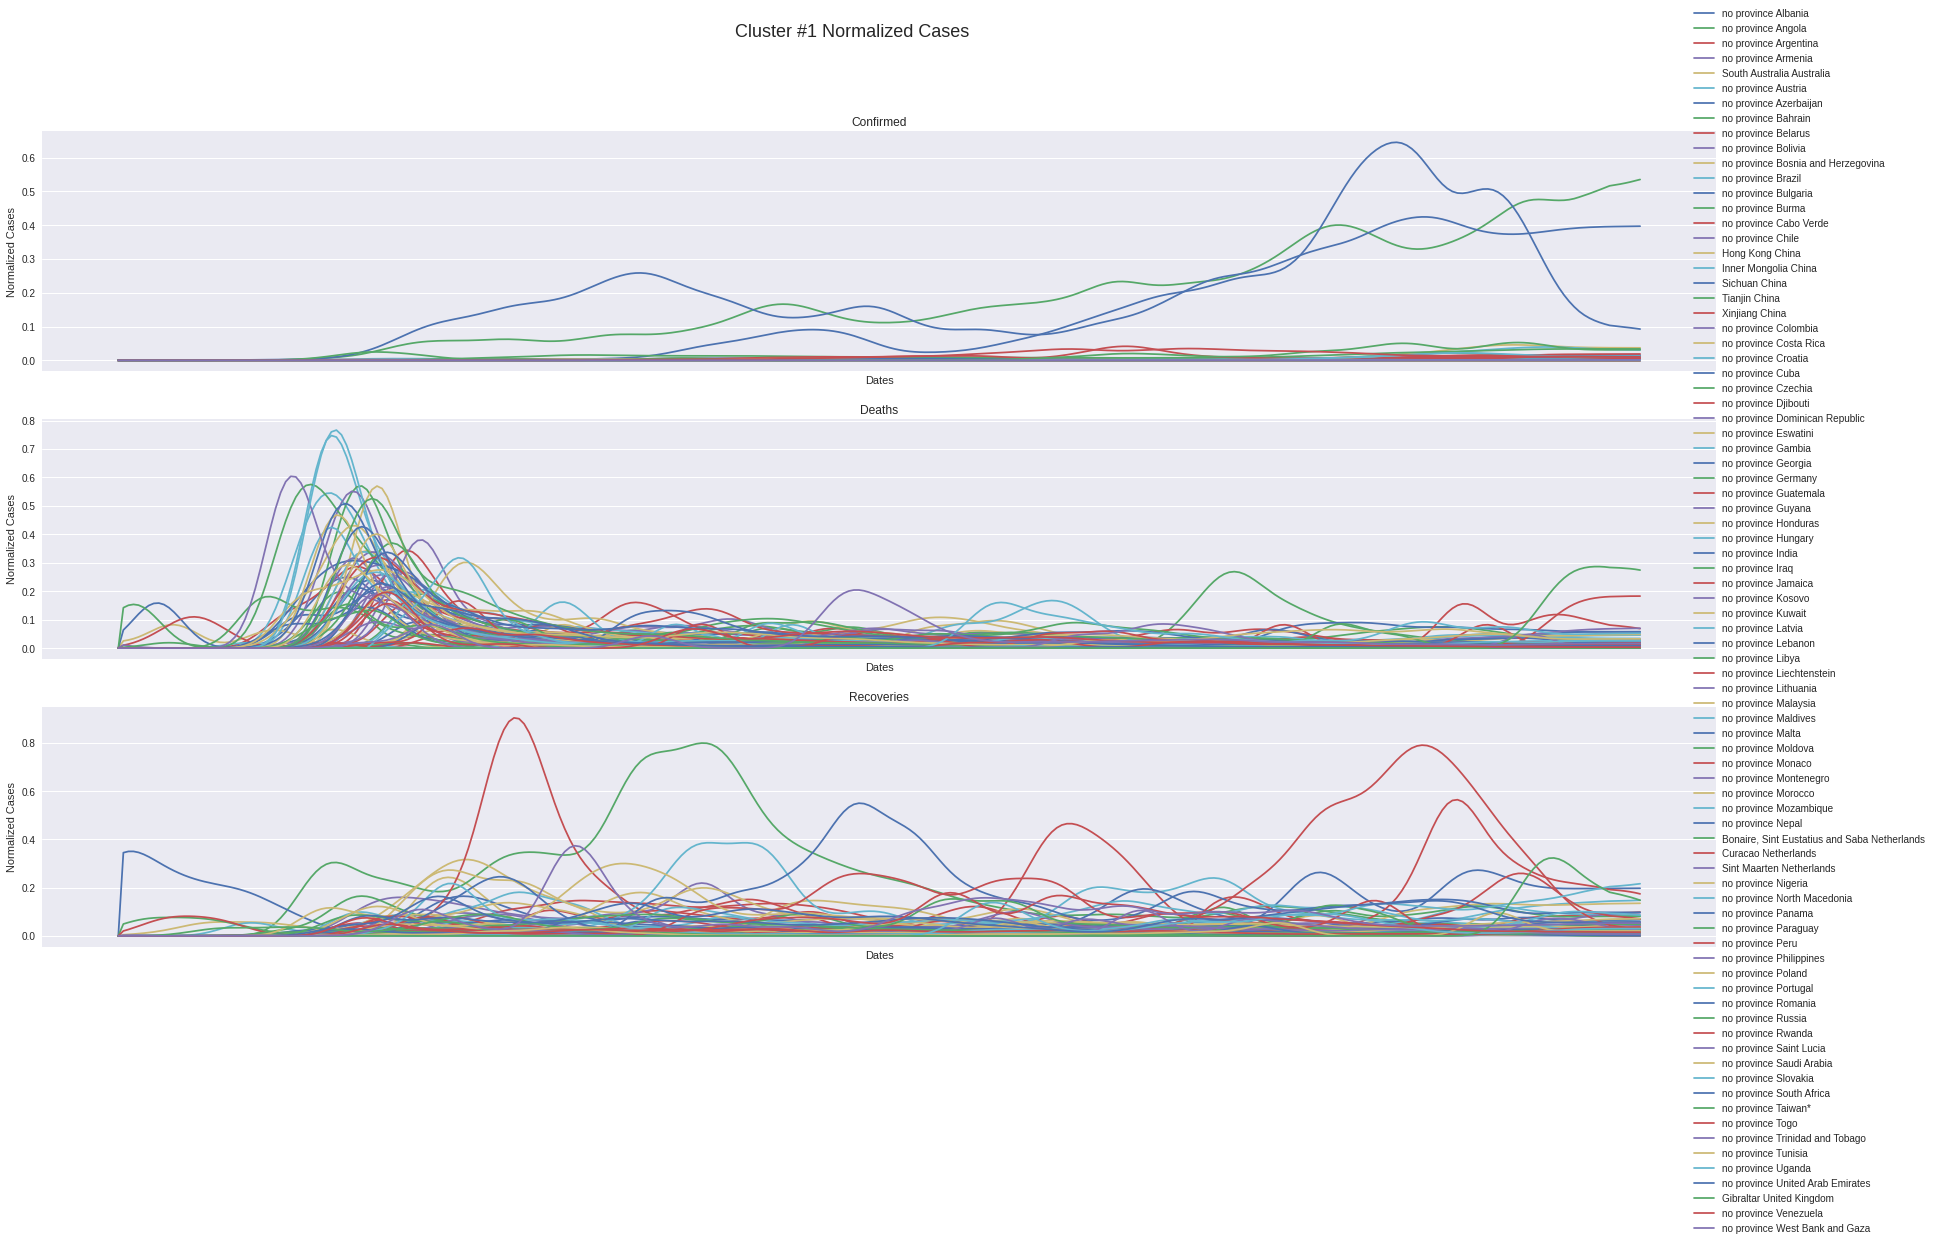

In [ ]:
get_graphs(df_kmeans, cluster_num=1)

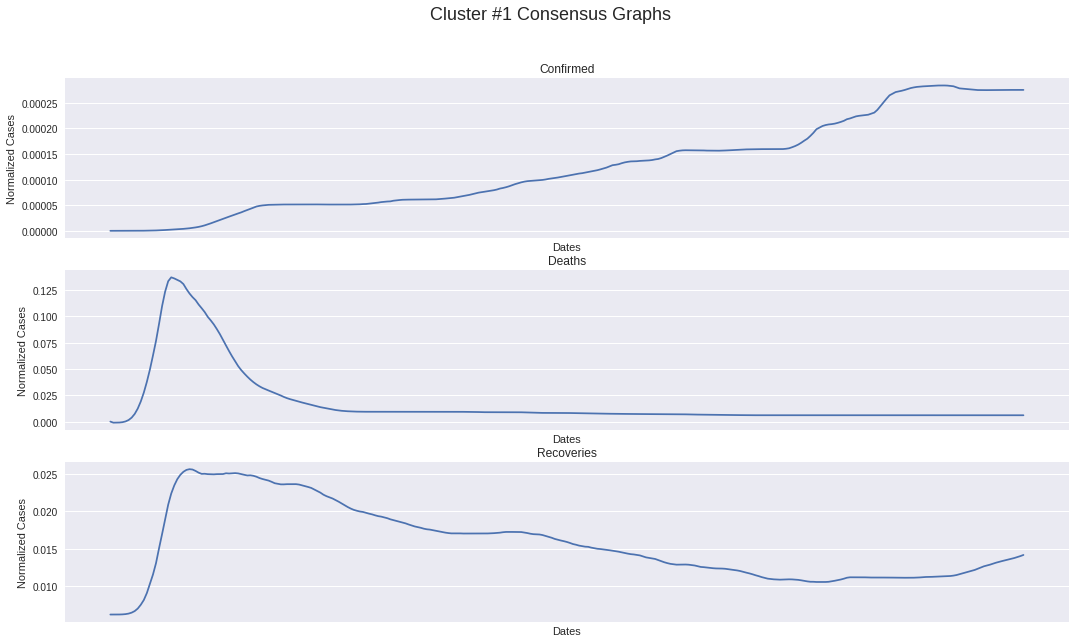

In [ ]:
cluster0_kmeans = get_consensus_2(df_kmeans, cluster_num=1)

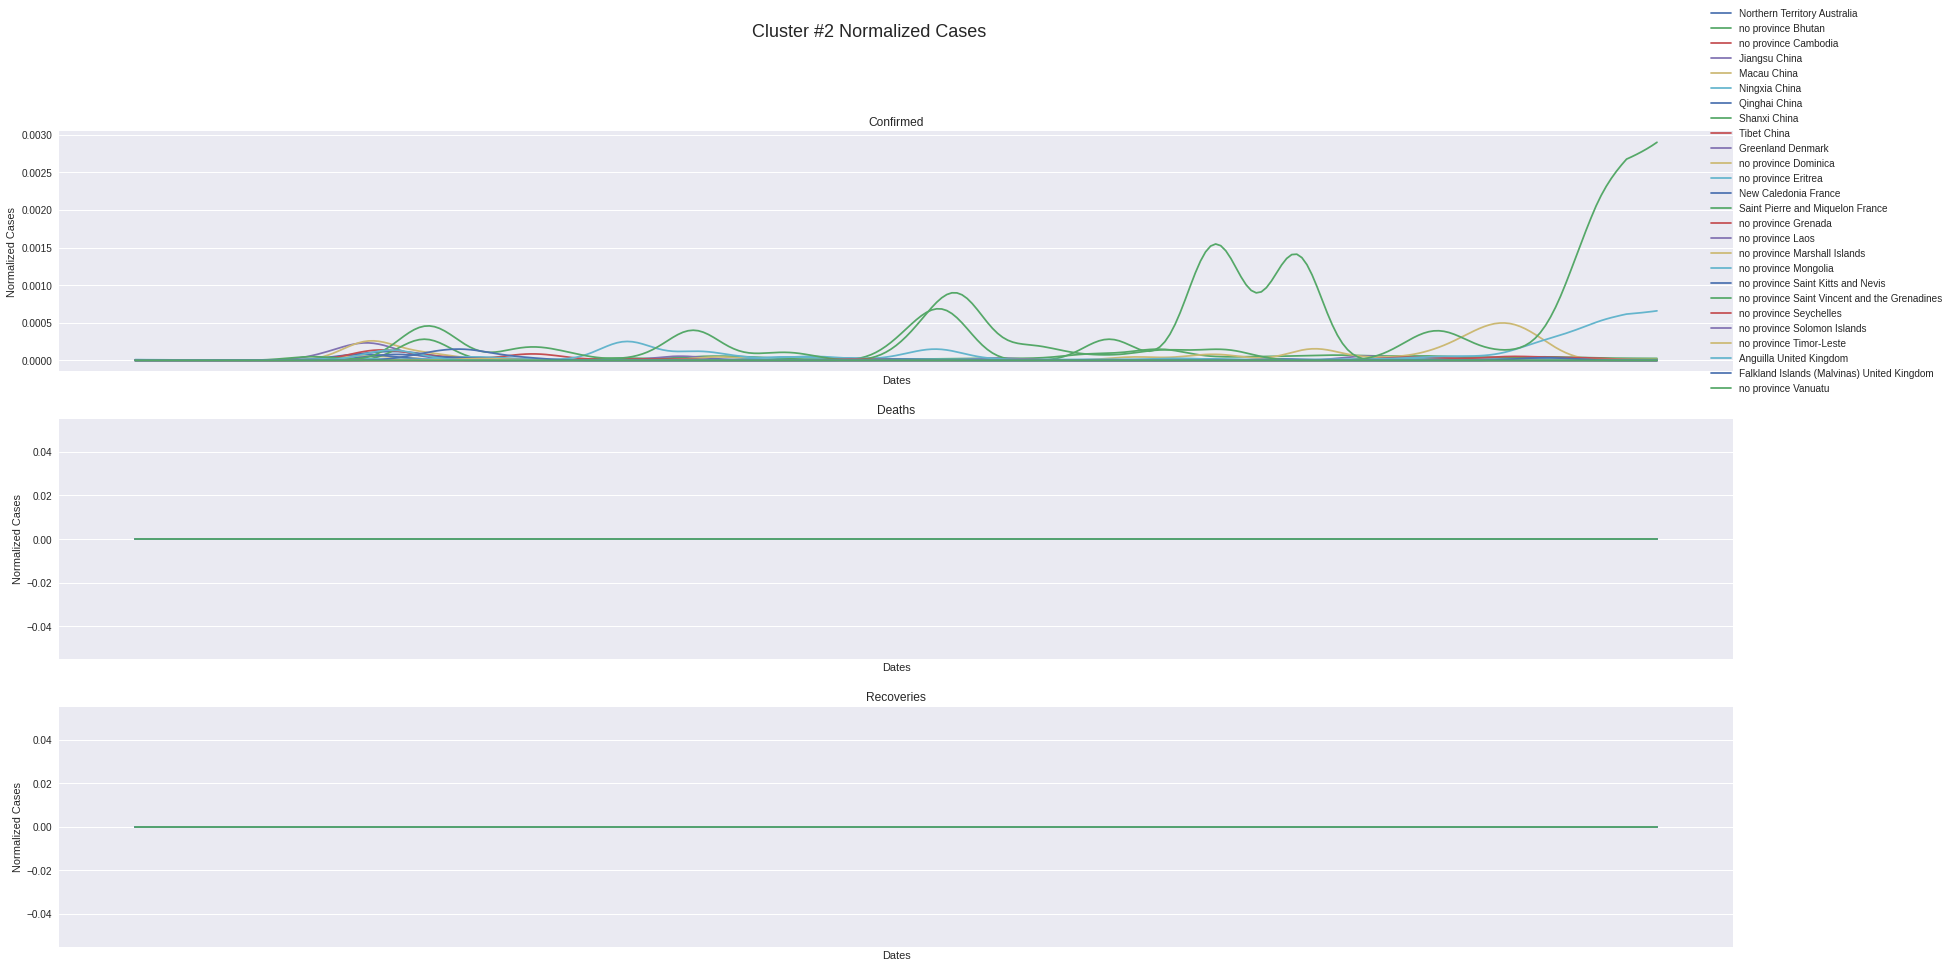

In [ ]:
get_graphs(df_kmeans, cluster_num=2)

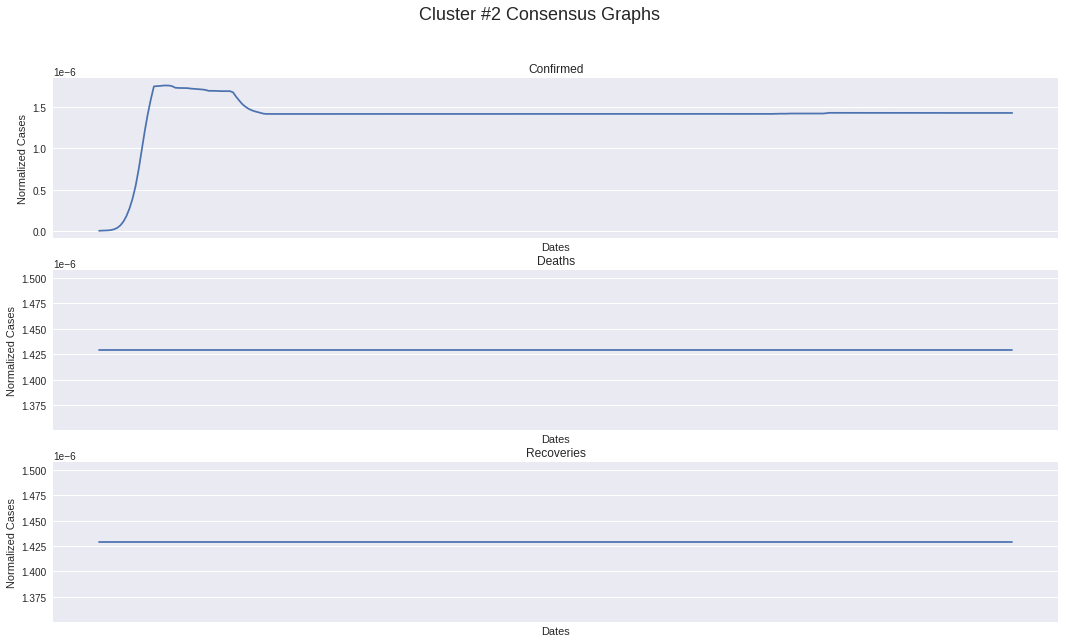

In [ ]:
cluster1_kmeans = get_consensus_2(df_kmeans, cluster_num=2)

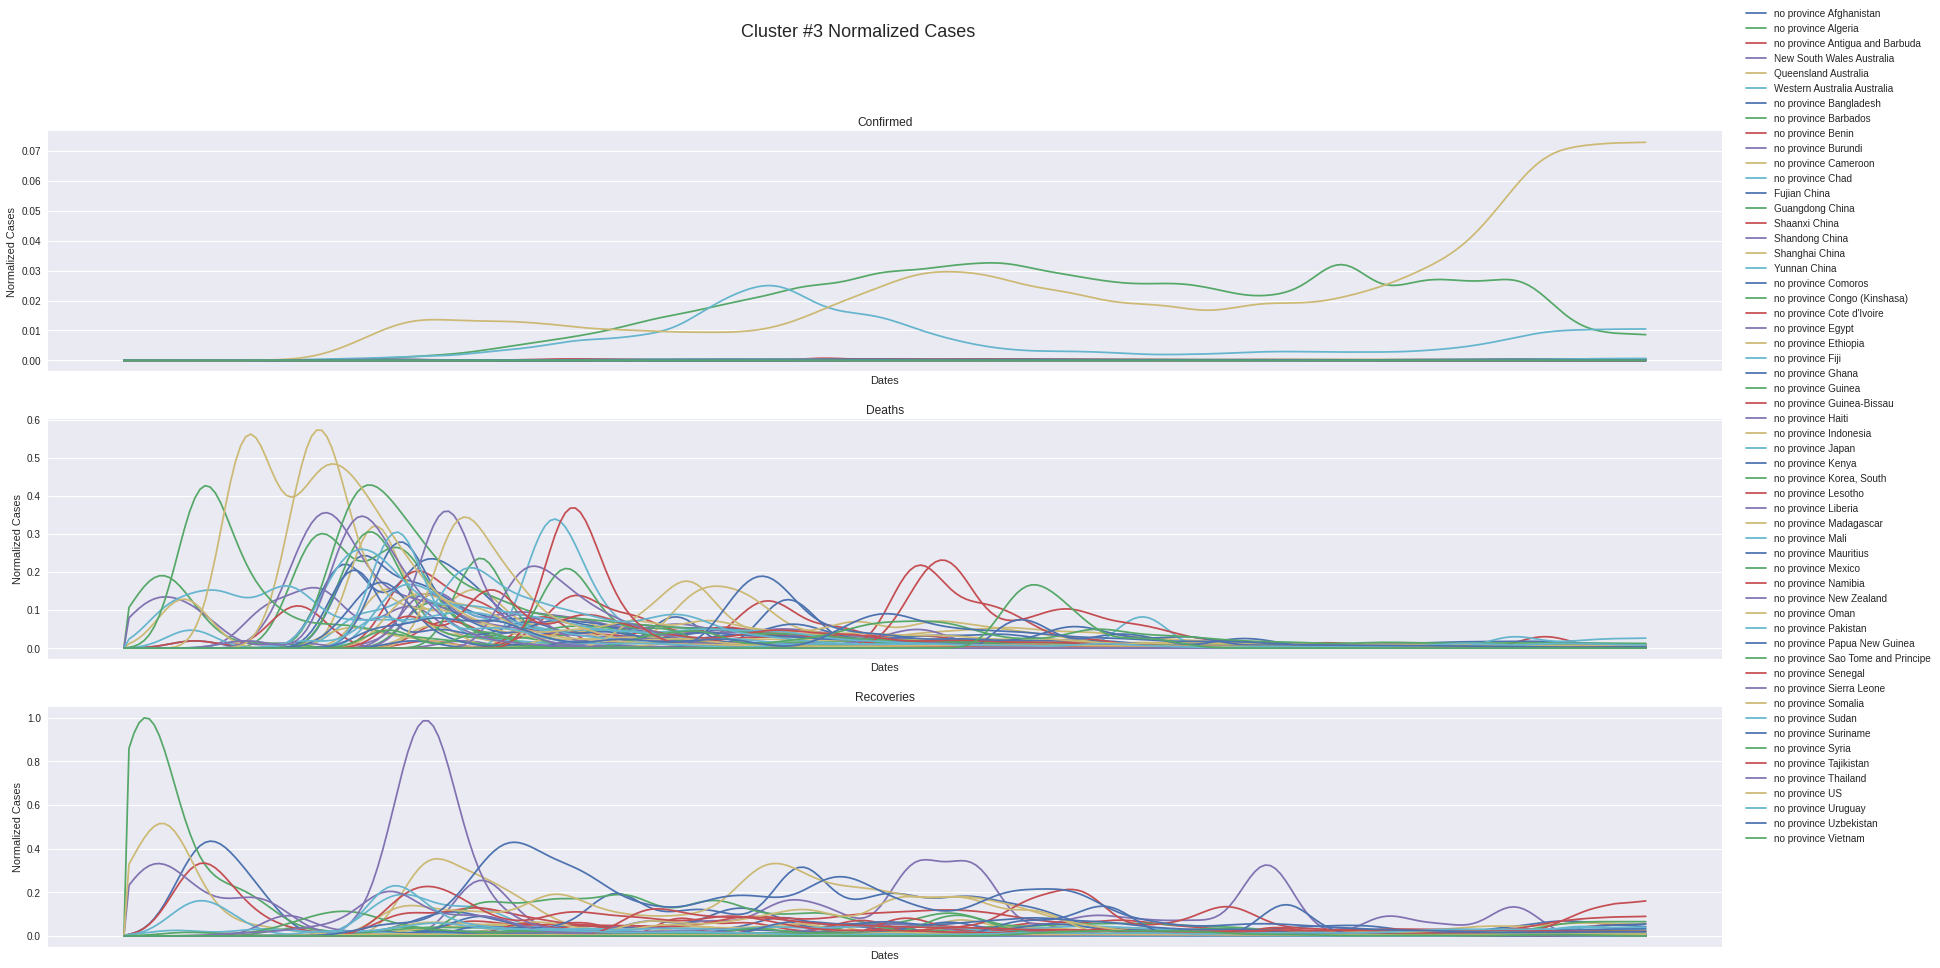

In [ ]:
get_graphs(df_kmeans, cluster_num=3)

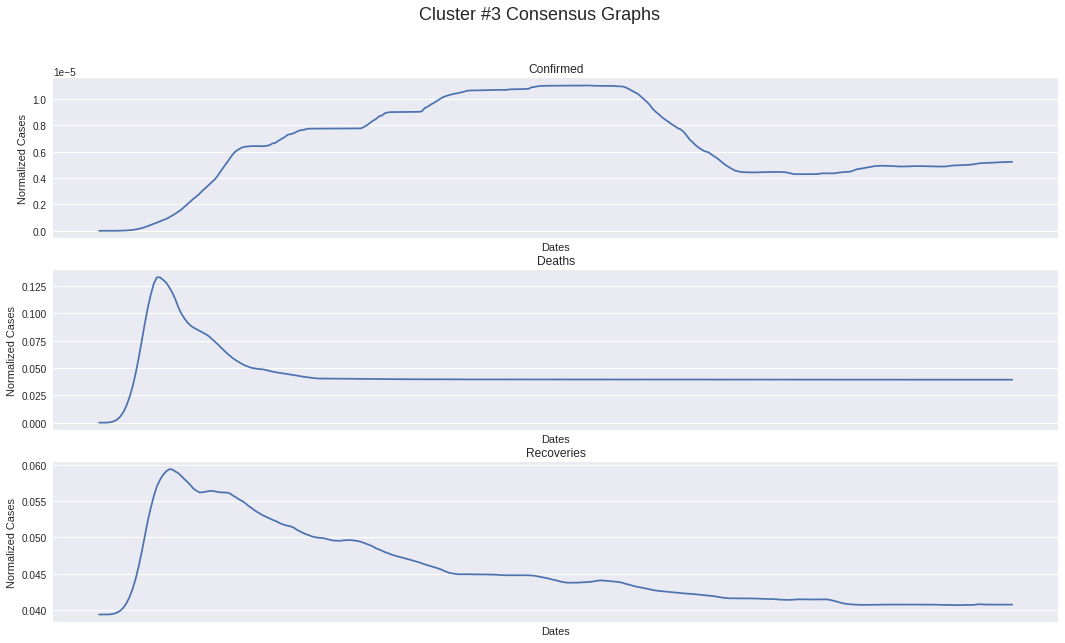

In [ ]:
cluster2_kmeans = get_consensus_2(df_kmeans, cluster_num=3)

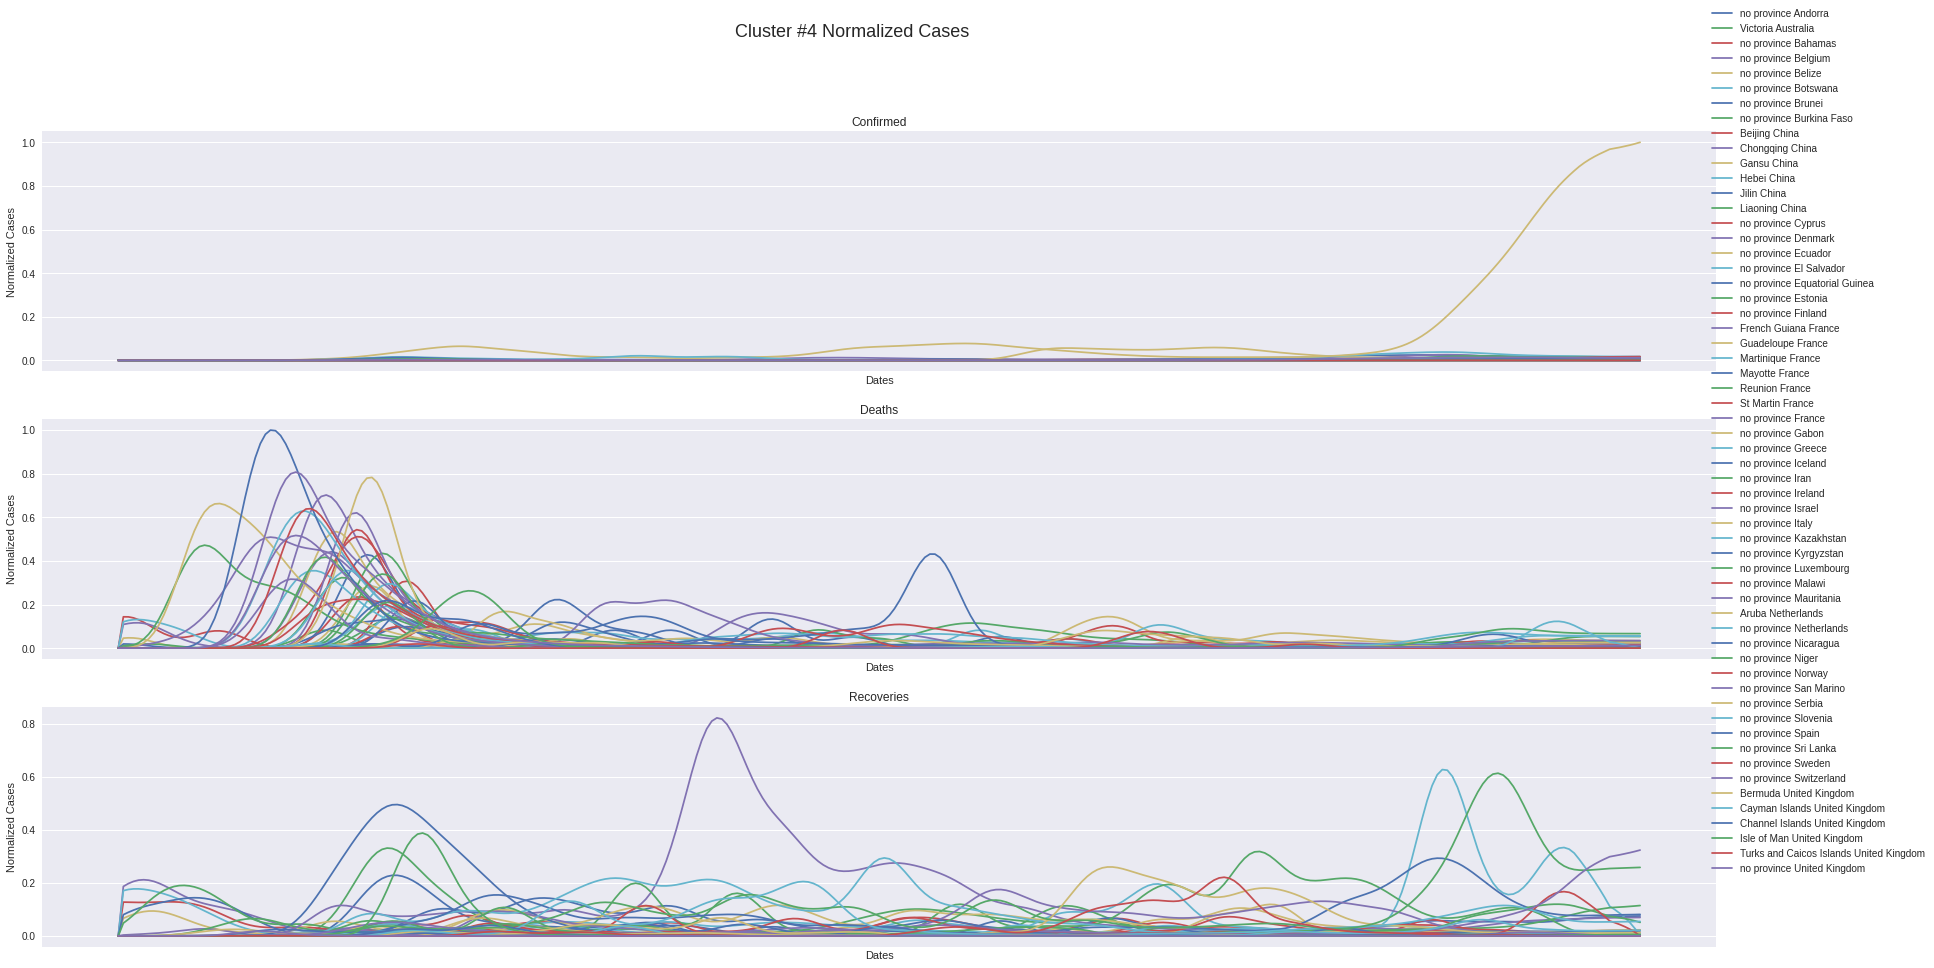

In [ ]:
get_graphs(df_kmeans, cluster_num=4)

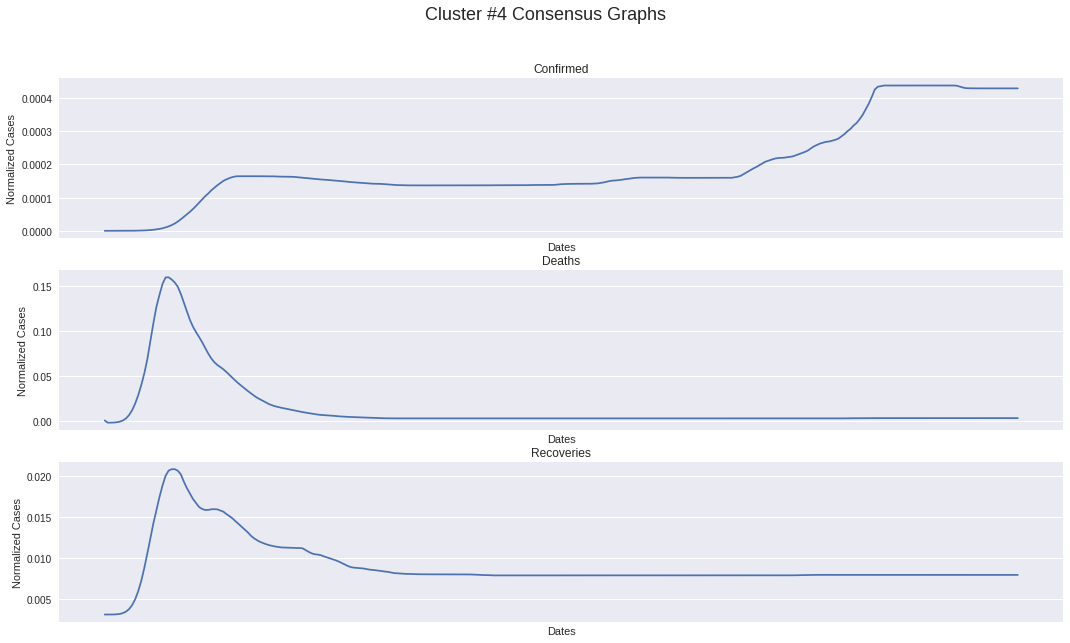

In [ ]:
cluster3_kmeans = get_consensus_2(df_kmeans, cluster_num=4)

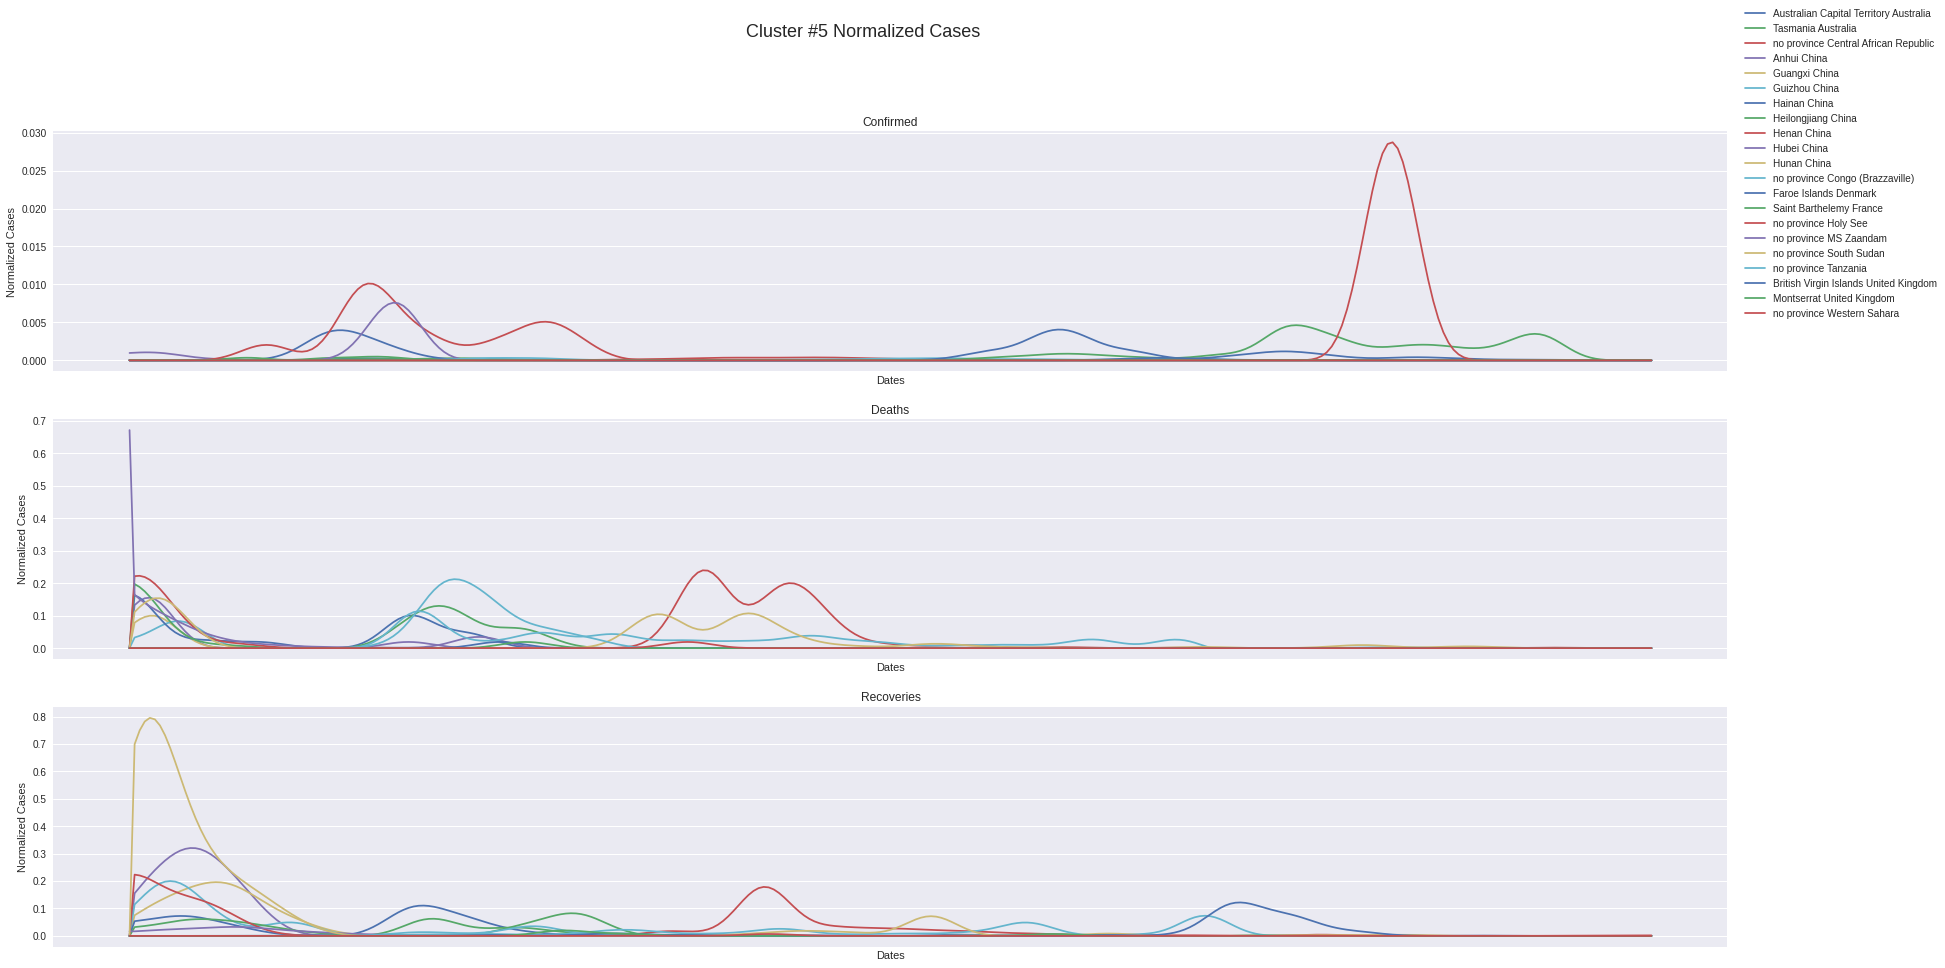

In [ ]:
get_graphs(df_kmeans, cluster_num=5)

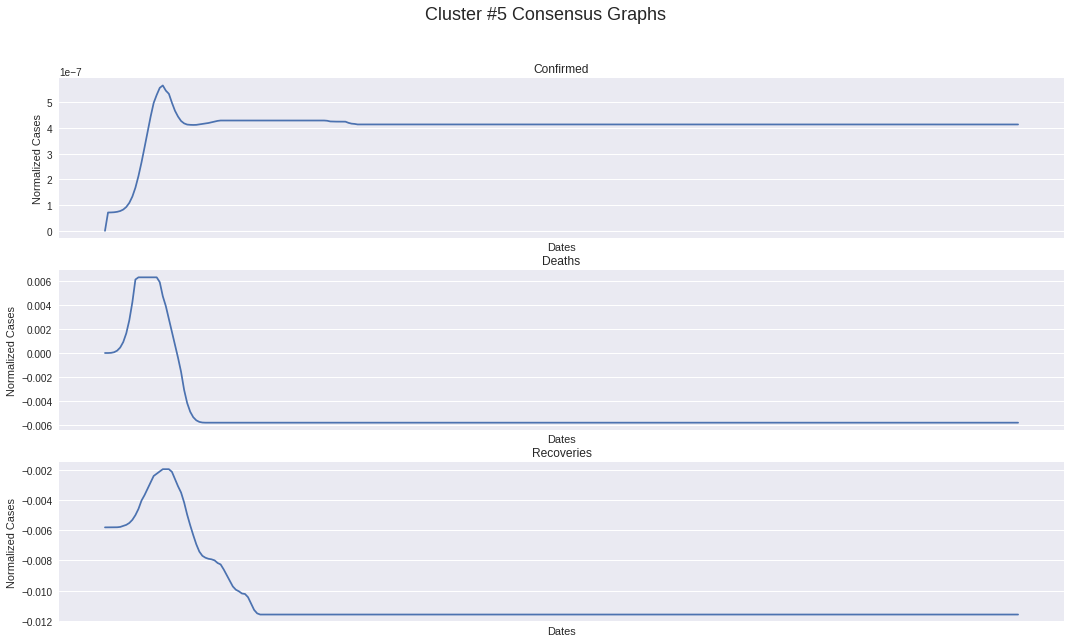

In [ ]:
cluster4_kmeans = get_consensus_2(df_kmeans, cluster_num=5)

## Consensus Shapes

In [32]:
# All countries
def get_all_consensus(df, num_divs=2):
  df = df.rename(columns={'label': 'alabel'})
  df = df.reindex(sorted(df.columns), axis=1)
  columns = df.columns[2:]
  num_columns = len(columns) // num_divs

  fig, ax = plt.subplots(num_divs, 1, figsize=(18,10))
  titles = ["Confirmed", "Deaths"]
  # titles = ["Confirmed", "Deaths", "Recoveries"]

  for i in range(num_divs):
    ax[i].set_title(titles[i])
    ax[i].set_xlabel("Dates")
    ax[i].set_ylabel("Normalized Cases")
    ax[i].get_xaxis().set_ticks([])

    x = columns[i*num_columns:i*num_columns + num_columns]
    for cluster_num in df['alabel'].unique():
      curr_df = df[df['alabel'] == cluster_num].iloc[0]
      y = curr_df[x]
        
      ax[i].plot(x,y,label=curr_df['area'])

  fig.suptitle('All Consensus Graphs'.format(cluster_num), fontsize=18)
  fig.legend(df['area'])

#### K-shape

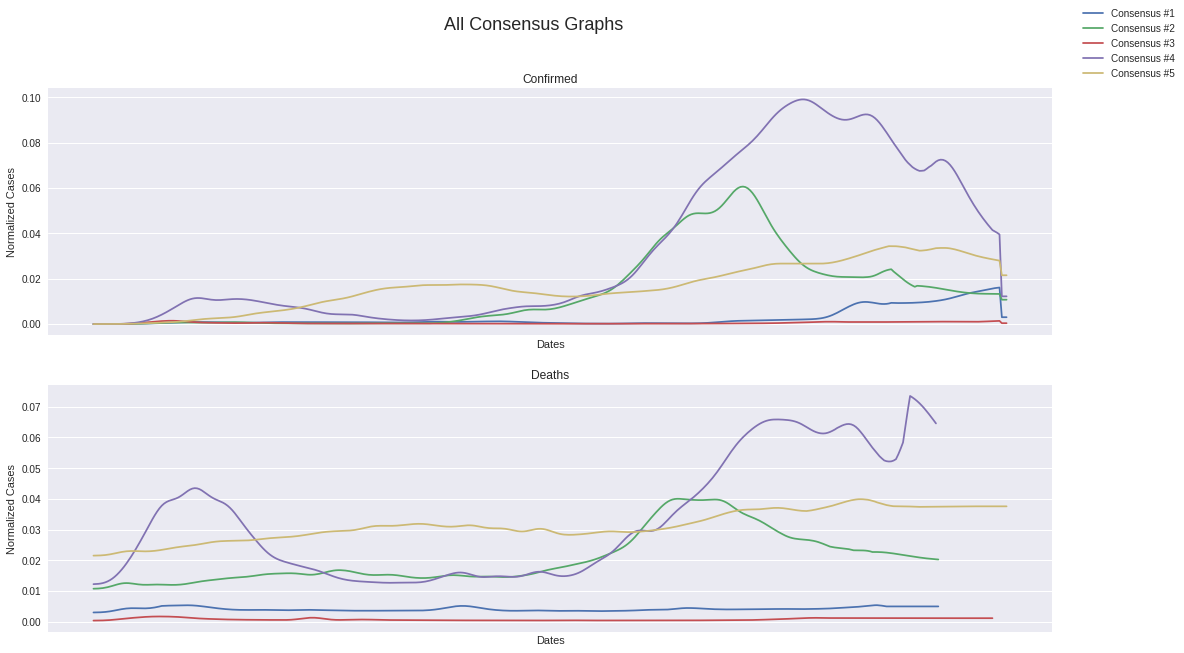

In [34]:
kshape_consensus = [
  cluster0_kshape,
  cluster1_kshape,
  cluster2_kshape,
  cluster3_kshape,
  cluster4_kshape,
]
df_consensus_kshape = pd.DataFrame(kshape_consensus)

get_all_consensus(df_consensus_kshape)

#### K-means

In [ ]:
kmeans_consensus = [
  cluster0_kmeans,
  cluster1_kmeans,
  cluster2_kmeans,
  cluster3_kmeans,
  cluster4_kmeans,
]
df_consensus_kmeans = pd.DataFrame(kmeans_consensus)

get_all_consensus(df_consensus_kmeans)

NameError: ignored

# World Map

## Getting the Data

In [35]:
# countries = df_kmeans[['Province/State', 'Country/Region', 'labels']]
# countries['labels_kshape'] = df_kshape['labels']
countries = df_kshape.loc[:, ['Province/State', 'Country/Region', 'labels']]
countries.head()

Province/State Country/Region  labels
0    no province    Afghanistan       5
1    no province        Albania       6
2    no province        Algeria       5
3    no province        Andorra       4
4    no province         Angola       2

In [36]:
# Obtained from: https://github.com/datasets/country-codes
country_codes = pd.read_csv(os.path.join(BASE_DIR, 'visualization/country_codes.csv'))
country_codes = country_codes.rename(columns={'CLDR display name': 'Country/Region'})
country_codes.head()

FIFA   Dial ISO3166-1-Alpha-3  ... Geoname ID  Country/Region  EDGAR
0  TPE    886               TWN  ...  1668284.0          Taiwan    NaN
1  AFG     93               AFG  ...  1149361.0     Afghanistan     B2
2  ALB    355               ALB  ...   783754.0         Albania     B3
3  ALG    213               DZA  ...  2589581.0         Algeria     B4
4  ASA  1-684               ASM  ...  5880801.0  American Samoa     B5

[5 rows x 56 columns]

#### Filling the NaN values

In [37]:
# Remove all provinces
countries = countries.drop(countries[countries.duplicated(['Country/Region'], keep='last')].index)

In [38]:
# Antigua and Barbuda
def change_country_name(df, old_value, new_value, column='Country/Region'):
  try:
    index = df[df[column] == old_value].index[0]
    df.at[index, column] = new_value
    print(f'Changed from {old_value} to {new_value}')
  except IndexError:
    print(f'{old_value} not found in the dataset!')

In [39]:
# Antigua and Barbuda
change_country_name(countries, 'Antigua and Barbuda', 'Antigua & Barbuda')

# Bosnia and Herzegovina
change_country_name(countries, 'Bosnia and Herzegovina', 'Bosnia')

# Myanmar
change_country_name(countries, 'Burma', 'Myanmar')

# Cape Verde
change_country_name(countries, 'Cabo Verde', 'Cape Verde')

# Congo (Brazzaville)
change_country_name(countries, 'Congo (Brazzaville)', 'Congo - Brazzaville')

# Congo (Kinshasa)
change_country_name(countries, 'Congo (Kinshasa)', 'Congo - Kinshasa')

# Côte d’Ivoire
change_country_name(countries, "Cote d'Ivoire", 'Côte d’Ivoire')

# Vatican City
change_country_name(countries, "Holy See", 'Vatican City')

# South Korea
change_country_name(countries, "Korea, South", 'South Korea')

# Kosovo - not in dataset
# change_country_name(countries, "Kosovo", 'Vatican City')

# MS Zaandam - not in dataset

# Saint Kitts and Nevis
change_country_name(countries, "Saint Kitts and Nevis", 'St. Kitts & Nevis')

# Saint Lucia
change_country_name(countries, "Saint Lucia", 'St. Lucia')

# Saint Vincent and the Grenadines
change_country_name(countries, "Saint Vincent and the Grenadines", 'St. Vincent & Grenadines')

# Sao Tome and Principe
change_country_name(countries, "Sao Tome and Principe", 'St. Lucia')

# Saint Lucia
change_country_name(countries, "Saint Lucia", 'St. Lucia')

# Taiwan
change_country_name(countries, "Taiwan*", 'Taiwan')

# Saint Lucia
change_country_name(countries, "Trinidad and Tobago", 'Trinidad & Tobago')

# UK
change_country_name(countries, "United Kingdom", 'UK')

# West Bank and Gaza - not in dataset

Antigua and Barbuda not found in the dataset!
Changed from Bosnia and Herzegovina to Bosnia
Changed from Burma to Myanmar
Changed from Cabo Verde to Cape Verde
Changed from Congo (Brazzaville) to Congo - Brazzaville
Changed from Congo (Kinshasa) to Congo - Kinshasa
Changed from Cote d'Ivoire to Côte d’Ivoire
Holy See not found in the dataset!
Changed from Korea, South to South Korea
Saint Kitts and Nevis not found in the dataset!
Changed from Saint Lucia to St. Lucia
Changed from Saint Vincent and the Grenadines to St. Vincent & Grenadines
Changed from Sao Tome and Principe to St. Lucia
Saint Lucia not found in the dataset!
Changed from Taiwan* to Taiwan
Changed from Trinidad and Tobago to Trinidad & Tobago
Changed from United Kingdom to UK


In [40]:
countries = countries.dropna()

#### Merging the Countries and JSON

In [41]:
new_countries = countries.merge(country_codes, how='left', on='Country/Region')[['Province/State', 'Country/Region', 'labels', 'ISO3166-1-Alpha-3']]
# new_countries = countries.merge(country_codes, how='left', on='Country/Region')[['Province/State', 'Country/Region', 'labels', 'labels_kshape', 'ISO3166-1-Alpha-3']]
new_countries = new_countries.rename(columns={'ISO3166-1-Alpha-3': 'ID'})
new_countries = new_countries[['ID', 'labels']]
# new_countries = new_countries[['ID', 'labels', 'labels_kshape']]
new_countries.head()

ID  labels
0  AFG       5
1  ALB       6
2  DZA       5
3  AND       4
4  AGO       2

### Visualizing the Data

In [42]:
# Import Countries JSON file
import json

# Obtained from: https://datahub.io/core/geo-countries
with open(os.path.join(BASE_DIR, 'visualization/countries_geojson.json')) as f:
  countries_geojson = json.load(f)

new_countries.head()

ID  labels
0  AFG       5
1  ALB       6
2  DZA       5
3  AND       4
4  AGO       2

#### K-Shape

In [43]:
import folium
m_kshape = folium.Map(location=[48, -102], zoom_start=1)
folium.Choropleth(
    geo_data=countries_geojson,
    name='choropleth',
    data=new_countries,
    columns=['ID', 'labels'],
    # columns=['ID', 'labels_kshape'],
    key_on='feature.properties.ISO_A3',
    fill_color='PuBuGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='COVID Cluster'
).add_to(m_kshape)

folium.LayerControl().add_to(m_kshape)

m_kshape

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# m.save('cluster_map_kmeans.html')
m_kshape.save('cluster_map_kshape.html')

#### K-Means

In [ ]:
import folium

m = folium.Map(location=[48, -102], zoom_start=1)
folium.Choropleth(
    geo_data=countries_geojson,
    name='choropleth',
    data=new_countries,
    columns=['ID', 'labels'],
    key_on='feature.properties.ISO_A3',
    fill_color='PuBuGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='COVID Cluster'
).add_to(m)

folium.LayerControl().add_to(m)

m

Output hidden; open in https://colab.research.google.com to view.